# LSTM Model Codes

## Simulated Dataset and function definitions

In [1]:
import os
import shutil
import random; random.seed(42)

import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch
from torch import nn
import jax
import jax.numpy as jnp
import numpy as np
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
from functools import partial # reduces arguments to function by making some subset implicit

from jax.experimental import stax
from jax.experimental import optimizers

# visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from moviepy.editor import ImageSequenceClip
from functools import partial
import proglog
from PIL import Image

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

def lagrangian(q, q_dot, m1, m2, l1, l2, g):
    t1, t2 = q     # theta 1 and theta 2
    w1, w2 = q_dot # omega 1 and omega 2

    # kinetic energy (T)
    T1 = 0.5 * m1 * (l1 * w1)**2
    T2 = 0.5 * m2 * ((l1 * w1)**2 + (l2 * w2)**2 +
                    2 * l1 * l2 * w1 * w2 * jnp.cos(t1 - t2))
    T = T1 + T2
  
    # potential energy (V)
    y1 = -l1 * jnp.cos(t1)
    y2 = y1 - l2 * jnp.cos(t2)
    V = m1 * g * y1 + m2 * g * y2

    return T - V

def f_analytical(state, t=0, m1=1, m2=1, l1=1, l2=1, g=9.8):
    t1, t2, w1, w2 = state
    a1 = (l2 / l1) * (m2 / (m1 + m2)) * jnp.cos(t1 - t2)
    a2 = (l1 / l2) * jnp.cos(t1 - t2)
    f1 = -(l2 / l1) * (m2 / (m1 + m2)) * (w2**2) * jnp.sin(t1 - t2) - \
      (g / l1) * jnp.sin(t1)
    f2 = (l1 / l2) * (w1**2) * jnp.sin(t1 - t2) - (g / l2) * jnp.sin(t2)
    g1 = (f1 - a1 * f2) / (1 - a1 * a2)
    g2 = (f2 - a2 * f1) / (1 - a1 * a2)
    return jnp.stack([w1, w2, g1, g2])

def equation_of_motion(lagrangian, state, t=None):
    q, q_t = jnp.split(state, 2)
    q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
    return jnp.concatenate([q_t, q_tt])

def solve_lagrangian(lagrangian, initial_state, **kwargs):
    # We currently run odeint on CPUs only, because its cost is dominated by
    # control flow, which is slow on GPUs.
    @partial(jax.jit, backend='cpu')
    def f(initial_state):
        return odeint(partial(equation_of_motion, lagrangian),
                  initial_state, **kwargs)
    return f(initial_state)

# Double pendulum dynamics via the rewritten Euler-Lagrange
@partial(jax.jit, backend='cpu')
def solve_autograd(initial_state, times, m1=1, m2=1, l1=1, l2=1, g=9.8):
    L = partial(lagrangian, m1=m1, m2=m2, l1=l1, l2=l2, g=g)
    return solve_lagrangian(L, initial_state, t=times, rtol=1e-10, atol=1e-10)

# Double pendulum dynamics via analytical forces taken from Diego's blog
@partial(jax.jit, backend='cpu')
def solve_analytical(initial_state, times):
    return odeint(f_analytical, initial_state, t=times, rtol=1e-10, atol=1e-10)

def normalize_dp(state):
    # wrap generalized coordinates to [-pi, pi]
    return jnp.concatenate([(state[:2] + np.pi) % (2 * np.pi) - np.pi, state[2:]])

def rk4_step(f, x, t, h):
    # one step of runge-kutta integration
    k1 = h * f(x, t)
    k2 = h * f(x + k1/2, t + h/2)
    k3 = h * f(x + k2/2, t + h/2)
    k4 = h * f(x + k3, t + h)
    return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

def make_plot(i, cart_coords, l1, l2, max_trail=30, trail_segments=20, r = 0.05):
    # Plot and save an image of the double pendulum configuration for time step i.
    plt.cla()

    x1, y1, x2, y2 = cart_coords
    ax.plot([0, x1[i], x2[i]], [0, y1[i], y2[i]], lw=2, c='k') # rods
    c0 = Circle((0, 0), r/2, fc='k', zorder=10) # anchor point
    c1 = Circle((x1[i], y1[i]), r, fc='b', ec='b', zorder=10) # mass 1
    c2 = Circle((x2[i], y2[i]), r, fc='r', ec='r', zorder=10) # mass 2
    ax.add_patch(c0)
    ax.add_patch(c1)
    ax.add_patch(c2)

    # plot the pendulum trail (ns = number of segments)
    s = max_trail // trail_segments
    for j in range(trail_segments):
        imin = i - (trail_segments-j)*s
        if imin < 0: continue
        imax = imin + s + 1
        alpha = (j/trail_segments)**2 # fade the trail into alpha
        ax.plot(x2[imin:imax], y2[imin:imax], c='r', solid_capstyle='butt',
                lw=2, alpha=alpha)

    # Center the image on the fixed anchor point. Make axes equal.
    ax.set_xlim(-l1-l2-r, l1+l2+r)
    ax.set_ylim(-l1-l2-r, l1+l2+r)
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    # plt.savefig('./frames/_img{:04d}.png'.format(i//di), dpi=72)

def radial2cartesian(t1, t2, l1, l2):
  # Convert from radial to Cartesian coordinates.
  x1 = l1 * np.sin(t1)
  y1 = -l1 * np.cos(t1)
  x2 = x1 + l2 * np.sin(t2)
  y2 = y1 - l2 * np.cos(t2)
  return x1, y1, x2, y2

def fig2image(fig):
  fig.canvas.draw()
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
  image = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  return image

def cart_coords_over_time(cart_coords):
    x1, y1, x2, y2 = cart_coords
    
    length = len(x2)
    t = np.arange(length)
    
    plt.title("LSTM Double Pendulum " + f"Timeseries - {length - 1} timesteps")

    plt.plot(x2, y2, marker='.', color="lightgray", zorder=0)
    plt.scatter(x2, y2, marker='o', c=t[:length], cmap="viridis", s=10, zorder=1)

    plt.xlabel("$x$")
    plt.ylabel("$y$")

    cbar = plt.colorbar()
    cbar.ax.set_ylabel('$t$', rotation=270)

    #plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

def predict(model, warming_up, gen_len):
    model.eval()
    outputs = []
    inputs = warming_up 
    for i in tqdm(range(gen_len)):
        output = np.array(model(torch.from_numpy(inputs)[None,:,:]).detach())
        outputs.append(output)
        inputs = np.concatenate((inputs[[1,2,3],:],output), axis = 0)
    return np.array(outputs).squeeze()

ALSA lib pulse.c:242:(pulse_connect) PulseAudio: Unable to connect: Timeout

ALSA lib pulse.c:242:(pulse_connect) PulseAudio: Unable to connect: Connection refused



cpu


In [2]:
class Dataset(torch.utils.data.Dataset):
    '''
    Generate a LSTM dataset from a normalized dataset
    '''
    def __init__(self,seq_list):
        self.X_list = []
        self.y_list = []
        for seq in tqdm(seq_list):
            for i in range(seq.shape[0] - 5):
                self.X_list.append(seq[[i,i+1,i+2,i+3],:])
                self.y_list.append(seq[i+4,:])
        self.sample_list = list(zip(self.X_list, self.y_list))
    
    def __getitem__(self,index):
        X_sample,y_sample = self.sample_list[index]
        return torch.from_numpy(X_sample).float(),torch.from_numpy(y_sample).float()
    
    def __len__(self):
        return len(self.sample_list)

In [3]:
seq_list = []
for i in tqdm(range(100)): #generate 10 sequences pf length 2000
    c1 = random.random()
    c2 = random.random()
    c3 = random.random()
    x = np.array([c1*np.pi, c2*np.pi, 0, 0], dtype=np.float32)
    t = np.linspace(0, 20, num=2000)
    x_analytical = jax.device_get(solve_analytical(x, t))
    seq_list.append(x_analytical)

dataset = Dataset(seq_list)
BATCH_SIZE = 256
trainDataLoader = torch.utils.data.DataLoader(dataset,batch_size=BATCH_SIZE)

100%|██████████| 100/100 [00:01<00:00, 59.99it/s]


In [4]:
test_list = []
for i in tqdm(range(10)): #generate 10 sequences pf length 2000
    c1 = random.random()
    c2 = random.random()
    x = np.array([c1*np.pi, c2*np.pi, 0, 0], dtype=np.float32)
    t = np.linspace(0, 20, num=305)
    x_analytical = jax.device_get(solve_analytical(x, t))
    test_list.append(x_analytical)
test_set=[]
for seq in test_list:
    x = seq[[0,1,2,3],:]
    y = seq[4:]
    test_set.append((x,y))

100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


### Model Definition

In [5]:
class LSTMModel(nn.Module):
    def __init__(self):
        # We want a model of 4 layer LSTM with 32 features output, and a dense layer to form the 4 feature output.
        super(LSTMModel, self).__init__()

        # Defining some parameters
        #self.hidden_size = 32
        #self.n_layers = 4

        #Defining the layers
        # LSTM layer
        self.lstm1 = nn.LSTM(input_size = 4, hidden_size = 32, num_layers = 1, batch_first = True)
        self.lstm2 = nn.LSTM(input_size = 32, hidden_size = 16, num_layers = 1, batch_first = True)
        self.lstm3 = nn.LSTM(input_size = 16, hidden_size = 8, num_layers = 1, batch_first = True)
        # Fully connected layer
        self.fc = nn.Linear(8, 4)
    
    def forward(self, x):
        out1, _= self.lstm1(x) # (h0.detach(), c0.detach())
        out2, _= self.lstm2(out1)
        out3, _= self.lstm3(out2)
        out3 = out3[:, -1, :]
        out = self.fc(out3)
        return out

### Hyperparameter and Model instantiate

In [7]:
# Instantiate the model with hyperparameters
model = LSTMModel()

# Define hyperparameters
n_epochs = 10
lr=0.01

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

valid_losses = []
train_losses = []
print('Training Start')
for epoch in tqdm(range(n_epochs)):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainDataLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            #print('[%d, %5d] loss: %.6f' %
                  #(epoch + 1, i + 1, running_loss / 100))
            train_losses.append(running_loss)
            running_loss = 0.0

    #validate
    index = 1 #random.randint(1,9)
    val_output = torch.from_numpy(predict(model, test_set[index][0],301))
    target = torch.from_numpy(test_set[index][1])
    valid_losses.append(criterion(val_output,target).item())

print('Finished Training')

Training Start


100%|██████████| 10/10 [02:26<00:00, 14.65s/it]

Finished Training


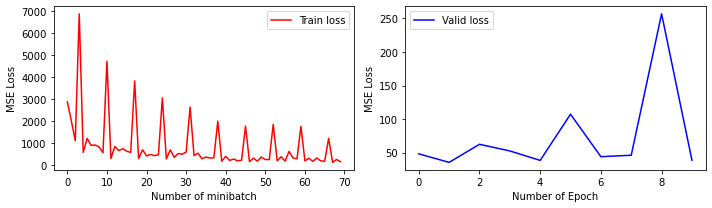

In [8]:
f = plt.figure(figsize=(10,3))
plt.title(f"Train Loss . Validaton Loss Comparison")

plt.subplot(1,2,1)
plt.plot(train_losses, color="Red", zorder=0, label='Train loss')
plt.xlabel("Number of minibatch")
plt.ylabel("MSE Loss")
plt.legend()
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(valid_losses, color="Blue", zorder=0, label='Valid loss')
plt.xlabel("Number of Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.tight_layout()

plt.show()

### Training

### Testing Data Loading

In [ ]:
output = predict(model, test_set[0][0], 301)

100%|██████████| 301/301 [00:00<00:00, 919.94it/s]


In [9]:
# choose an initial state
x1 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)

t2 = np.linspace(0, 20, num=301)
%time x1_analytical = jax.device_get(solve_analytical(x1, t2))

CPU times: user 1.3 s, sys: 16 ms, total: 1.32 s
Wall time: 1.31 s


In [10]:
x1_analytical.shape

(301, 4)

In [11]:
tai_output = predict(model, x1_analytical[[0,1,2,3],:], 301)

100%|██████████| 301/301 [00:00<00:00, 666.32it/s]


In [12]:
L1, L2 = 1, 1
theta1mod, theta2mod = tai_output[:, 0], tai_output[:, 1]
cart_coords_mod_tai = radial2cartesian(theta1mod, theta2mod, L1, L2)

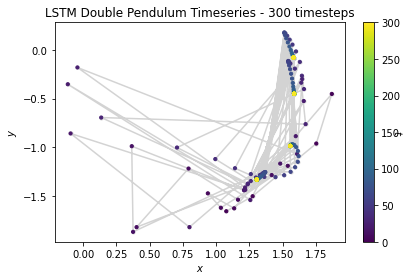

In [13]:
cart_coords_over_time(cart_coords_mod_tai)

100%|██████████| 300/300 [00:24<00:00, 12.23it/s]

Moviepy - Building video LSTMDoublePendulumMotion.mp4.
Moviepy - Writing video LSTMDoublePendulumMotion.mp4



TypeError: must be real number, not NoneType

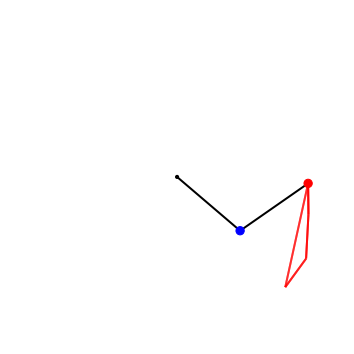

In [14]:
fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

import warnings
warnings.filterwarnings("ignore")

images = []
di = 1
N = 300
for i in tqdm(range(0, N, di)):
  #print("{}/{}".format(i // di, N // di), end='\n' if i//di%20==0 else ' ')
  make_plot(i, cart_coords_mod_tai, 1, 1)
  images.append( fig2image(fig) )

analytical_clip = ImageSequenceClip(images, fps=25)
analytical_clip.write_videofile("LSTMDoublePendulumMotion.mp4")

In [ ]:
L1, L2 = 1, 1
theta1mod, theta2mod = output[:, 0], output[:, 1]
cart_coords_mod = radial2cartesian(theta1mod, theta2mod, L1, L2)

L1, L2 = 1, 1
theta1ana, theta2ana = test_set[0][1][:, 0], test_set[0][1][:, 1]
cart_coords_ana = radial2cartesian(theta1ana, theta2ana, L1, L2)

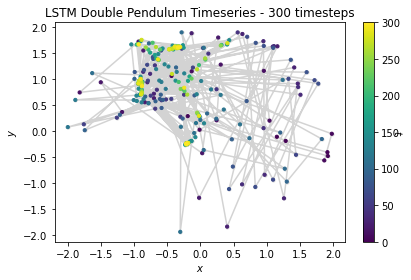

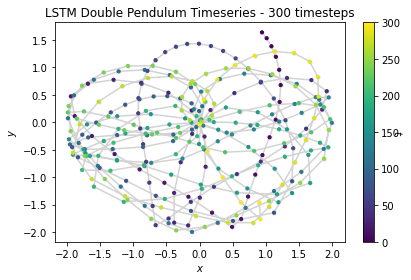

In [ ]:
cart_coords_over_time(cart_coords_mod)
cart_coords_over_time(cart_coords_ana)